In [1]:
import os
import sys
import logging
import argparse

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from PIL import Image
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import torch
from torchvision import transforms

from detectron2.data import MetadataCatalog
from detectron2.structures import BitMasks
from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from detectron2.utils.colormap import random_color
from utils.visualizer import Visualizer
from utils.distributed import init_distributed

import warnings
warnings.filterwarnings(action='ignore')
logger = logging.getLogger(__name__)

from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)

cmdline_args = parser.parse_args('')

In [3]:
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/svlp_focalt_lang.yaml")]
cmdline_args.overrides = ['WEIGHT', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides

['WEIGHT', '../checkpoints/xdecoder_focalt_best_openseg.pt']

In [4]:
opt = load_opt_from_config_files(cmdline_args.conf_files)

keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
types = []
for key in keys:
    key = key.split('.')
    ele = opt.copy()
    while len(key) > 0:
        ele = ele[key.pop(0)]
    types.append(type(ele))

config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}
config_dict

load_config_dict_to_opt(opt, config_dict)
for key, val in cmdline_args.__dict__.items():
    if val is not None:
        opt[key] = val

In [5]:
opt = init_distributed(opt)

In [6]:
pretrained_pth = os.path.join(opt['WEIGHT'])
output_root = './output'
# image_pth = '../images/owls.jpeg'
image_pth = '../images/COCO_val2014_000000565248.jpg'

In [7]:
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()

*UNLOADED* sem_seg_head.predictor.pos_embed_caping.weight, Model Shape: torch.Size([77, 512])
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])
$UNUSED$ sem_seg_head.predictor.query_feat_caping.weight, Ckpt Shape: torch.Size([77, 512])


In [8]:
model

BaseModel(
  (model): GeneralizedXdecoder(
    (backbone): D2FocalNet(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0): FocalModulationBlock(
              (dw1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (modulation): FocalModulation(
                (f): Linear(in_features=96, out_features=196, bias=True)
                (h): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
                (act): GELU(approximate='none')
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (foca

In [9]:
t = []
t.append(transforms.Resize(800, interpolation=Image.BICUBIC))
transform = transforms.Compose(t)
transform

Compose(
    Resize(size=800, interpolation=bicubic, max_size=None, antialias=None)
)

In [10]:
from datasets.utils.vcoco_utils import coco_class_list
print(coco_class_list)
thing_classes = ["person", "surfboard", "horse", "sea", "sky"]
thing_colors = [random_color(rgb=True, maximum=255).astype(np.int64).tolist() for _ in range(len(thing_classes))]
thing_dataset_id_to_contiguous_id = {x:x for x in range(len(thing_classes))}


['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', None]


In [11]:
MetadataCatalog.get("demo").set(
    thing_colors=thing_colors,
    thing_classes=thing_classes,
    thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
)
model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(thing_classes + ["background"], is_eval=False)
metadata = MetadataCatalog.get('demo')
model.model.metadata = metadata
model.model.sem_seg_head.num_classes = len(thing_classes)

(483, 640, 3)


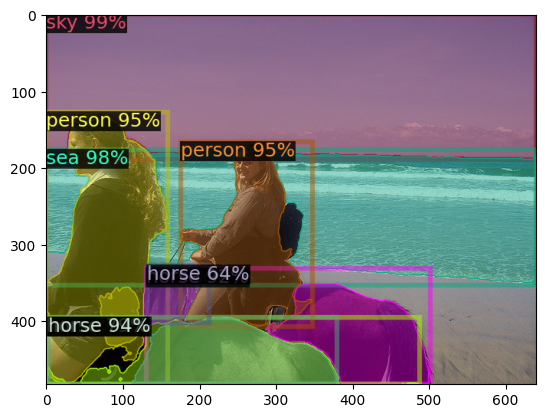

In [12]:
from matplotlib import pyplot as plt
with torch.no_grad():
    image_ori = Image.open(image_pth).convert('RGB')
    width = image_ori.size[0]
    height = image_ori.size[1]
    image = transform(image_ori)
    image = np.asarray(image)
    image_ori = np.asarray(image_ori)
    images = torch.from_numpy(image.copy()).permute(2,0,1).cuda()
    # print(images.shape)
    batch_inputs = [{'image': images, 'height': height, 'width': width}]
    outputs = model.forward(batch_inputs)

    # for key, val in outputs[-1].items():
    #     print(key, val)

    visual = Visualizer(image_ori, metadata=metadata)

    inst_seg = outputs[-1]['instances']
    inst_seg.pred_masks = inst_seg.pred_masks.cpu()
    tensor = inst_seg.pred_masks > 0

    boxes = torch.zeros(tensor.shape[0], 4, dtype=torch.float32)
    x_any = torch.any(tensor, dim=1)
    y_any = torch.any(tensor, dim=2)

    for idx in range(tensor.shape[0]):
        x = torch.where(x_any[idx, :])[0]
        y = torch.where(y_any[idx, :])[0]
        
        if len(x) > 0 and len(y) > 0:
            boxes[idx, :] = torch.as_tensor(
                [x[0], y[0], x[-1] + 1, y[-1] + 1], dtype=torch.float32
            )
    inst_seg.pred_boxes = boxes
    demo = visual.draw_instance_predictions(inst_seg) # rgb Image

    # if not os.path.exists(output_root):
    #     os.makedirs(output_root)
    # demo.save(os.path.join(output_root, 'inst3.png'))
    image = demo.get_image()
    print(image.shape)
    plt.imshow(image)
    plt.show()
